# Avaliação em holdouts - Palco 2010

* Exp1: 10 last examples of each user 
* Exp7: 10 last examples, and dont remove items that are in holdout from train data, and allow seen items, and dont remove items sent to holdout from bucket

# Import stuff

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/../..')

In [2]:
from data import ImplicitData, getBucketsHoldouts
from plot_utils import lineplot_recallxholdout, recall_heatmap
from dataset_evaluation_utils import *
from recommenders_implicit import ISGD, RAISGD, RSISGD, UserKNN  # ISGD framework, BISGD,
from eval_implicit import EvaluateHoldouts, EvaluateAndStore, EvalPrequential # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout

from datetime import datetime
import joblib
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

___
# BWT FWT

ACC, BWT, e FWT - Lopez-Paz e Ranzato GEM

In [3]:
def avg_recall(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    return np.mean( np.diag(results_matrix) )

def compute_BWT(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    BWT = []
    n_checkpoints = results_matrix.shape[0]
    for T in range(1, n_checkpoints): # 1 means holdout 2, 2 means 3, so on
        Rti = results_matrix.iloc[T, 0:T] # get models performances' on previous holdouts
        Rii = np.diag(results_matrix)[0:T] # get models performances' on their closest holdouts (diagonal)
        E = sum( Rti - Rii ) # future models performances' - performances' of models closest to holdouts (diagonal)
        BWT.append( E/T ) # store average BWT for model
    return BWT, np.mean( BWT ) # return BWT and average BWT for all models

def compute_FWT(results_matrix): # Díaz-Rodriguez et al. 2018
    upper_tri = results_matrix.to_numpy()[np.triu_indices(results_matrix.shape[0], k=1)]
    return np.mean(upper_tri)

___
# Read Data

In [4]:
# importa dataset 'palco playlists'
data = pd.read_csv('../output/palco_2010_dump/sampled_palco2010.csv')
user_col = 'user_id'
item_col = 'track_id'

In [5]:
data.shape, data.user_id.nunique(), data.track_id.nunique()

((435621, 7), 2921, 22103)

In [6]:
data[['user_id', 'track_id']].duplicated().sum()

210466

In [7]:
data.shape

(435621, 7)

In [8]:
data.head()

,user_id,track_id,timestamp,date2,year,month,date
0,4220,31313,2010-01-01 00:10:36,2010-01-01,2010,1,2010-01-01
1,4220,29567,2010-01-01 00:13:07,2010-01-01,2010,1,2010-01-01
2,4220,31313,2010-01-01 00:13:18,2010-01-01,2010,1,2010-01-01
3,6258,18106,2010-01-01 00:46:25,2010-01-01,2010,1,2010-01-01
4,42186,5066,2010-01-01 00:50:59,2010-01-01,2010,1,2010-01-01


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435621 entries, 0 to 435620
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    435621 non-null  int64 
 1   track_id   435621 non-null  int64 
 2   timestamp  435621 non-null  object
 3   date2      435621 non-null  object
 4   year       435621 non-null  int64 
 5   month      435621 non-null  int64 
 6   date       435621 non-null  object
dtypes: int64(4), object(3)
memory usage: 23.3+ MB


### Convert timestamp

In [10]:
%%time 
# 2.42s
data['date'] = data['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
# data.sort_values(by='timestamp', inplace=True)

CPU times: user 6.09 s, sys: 60.8 ms, total: 6.15 s
Wall time: 6.31 s


CPU times: user 180 ms, sys: 6.17 ms, total: 186 ms
Wall time: 225 ms


Text(0.5, 1.0, 'interactions per month')

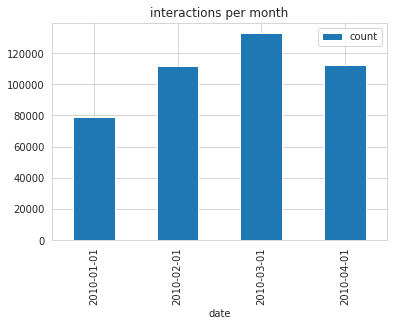

In [11]:
%%time
# 198ms
interactions_per_month = data.groupby(by=['date']).count().iloc[:, 0]
interactions_per_month.name = 'count'
interactions_per_month=interactions_per_month.reset_index()
_ = interactions_per_month.copy()
_['date'] = _['date'].dt.date
_.groupby('date').sum().plot(kind='bar')
plt.title('interactions per month')

**LIMITING TO THREE MONTHS - it takes TOO long to run**
data

In [12]:
data = data[ data['date'] <= pd.to_datetime('2010-03-01T00:00:00.000000000') ]

# Hyperparameters

In [13]:
# define hyperparameters
K = 10
similarity = 'cosine'

# **Running only exp 7 - exp 7 is best performer in ISGD - UKNN takes too long**

# EXPERIMENT 7

CODE TO GET LAST N INTERACTIONS FROM EACH USER AS HOLDOUT  
* IF USER DID NOT INTERACT WITH AT LEAST N+1 ITEMS, THEN IT IS NOT USED FOR HOLDOUT  
* LAST 10 INTERACTIONS FROM EACH USER AS HOLDOUT
* RECOMENDING SEEN ITEMS IS ALLOWED
* DON'T REMOVE INTERACTIONS IN HOLDOUT FROM BUCKETS
* DON'T REMOVE INTERACTIONS **SENT** TO HOLDOUT FROM BUCKET

In [14]:
# CODE TO GET LAST N INTERACTIONS FROM EACH USER AS HOLDOUT
# IF USER DID NOT INTERACT WITH AT LEAST N+1 ITEMS, THEN IT IS NOT USED FOR HOLDOUT

N = 10
cold_start_buckets = 0
#     print('0',data.shape[0]) # debug
print('Creating buckets. . .')
buckets = []
# assert interval_type in ['W', 'M', 'QS', 'F'], "interval must be one of W, M, QS, or F"
# create buckets based on months
months = data['date'].unique()
for interval in months:
    idx = (data['date'] == interval)
    buckets.append( data[idx] )

print('Creating holdouts. . .')
# create holdouts with last user interaction
holdouts = []

for i, b in enumerate( buckets ):
    if i >= cold_start_buckets:
        condition = (b[user_col].value_counts() > N)
        frequent_users = b[user_col].value_counts()[ condition ].index
        holdout_idx = []
        for u in frequent_users:
            tail_idx = list( b[b[user_col] == u].tail(N).index )
            holdout_idx += tail_idx
        holdout = b.loc[holdout_idx].reset_index(drop=True)
        holdouts.append(holdout)
        # buckets[i] = b.drop(index=holdout_idx).reset_index(drop=True)
        buckets[i] = b.reset_index(drop=True)

Creating buckets. . .
Creating holdouts. . .


In [15]:
print('Converting to ImplicitData. . .')
for i, b in enumerate(buckets):
    buckets[i] = ImplicitData(user_list=b[user_col], item_list=b[item_col]) # convert to ImplicitData

for j, h in enumerate(holdouts):
    holdouts[j] = ImplicitData(user_list=h[user_col], item_list=h[item_col]) # convert to ImplicitData

print('Done!')
# return buckets, holdouts

Converting to ImplicitData. . .
Done!


In [16]:
sum( [b.size for b in buckets] ) + sum( [h.size for h in holdouts] )

354442

In [17]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte. recebe listas
# stream = ImplicitData(data[user_col], data[item_col])
# O modelo deve ser iniciado com uma lista vazia
empty_stream = ImplicitData([], [])
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = UserKNN(empty_stream, k=K, similarity=similarity)

In [18]:
# criamos instancia de EvaluateHoldouts para treinar o modelo e criar checkpoints
eval = EvaluateHoldouts(model=model, buckets=buckets, holdouts=holdouts)

In [23]:
%%time
# 28min 20s
eval.Train_Evaluate(N_recommendations=20, exclude_known_items=False, default_user='none')

----------------------------------------------------------------------------------------------------
Train bucket 0
Test Holdout 0
Test Holdout 1
recommendations not made for users in holdout 1 x checkpoint 0: 5100
Test Holdout 2
recommendations not made for users in holdout 2 x checkpoint 0: 6500
----------------------------------------------------------------------------------------------------
Train bucket 1
Test Holdout 0
Test Holdout 1
Test Holdout 2
recommendations not made for users in holdout 2 x checkpoint 1: 4340
----------------------------------------------------------------------------------------------------
Train bucket 2
Test Holdout 0
Test Holdout 1
Test Holdout 2
CPU times: user 6d 11h 23s, sys: 56 s, total: 6d 11h 1min 19s
Wall time: 6d 11h 27min 1s


In [24]:
rm = eval.results_matrix
df_exp7 = pd.DataFrame(rm)
# df.to_csv('output/palco_2010_dump/sample_palco2010 month_bucket ISGD results.csv', index=False)

# Result EXP 7

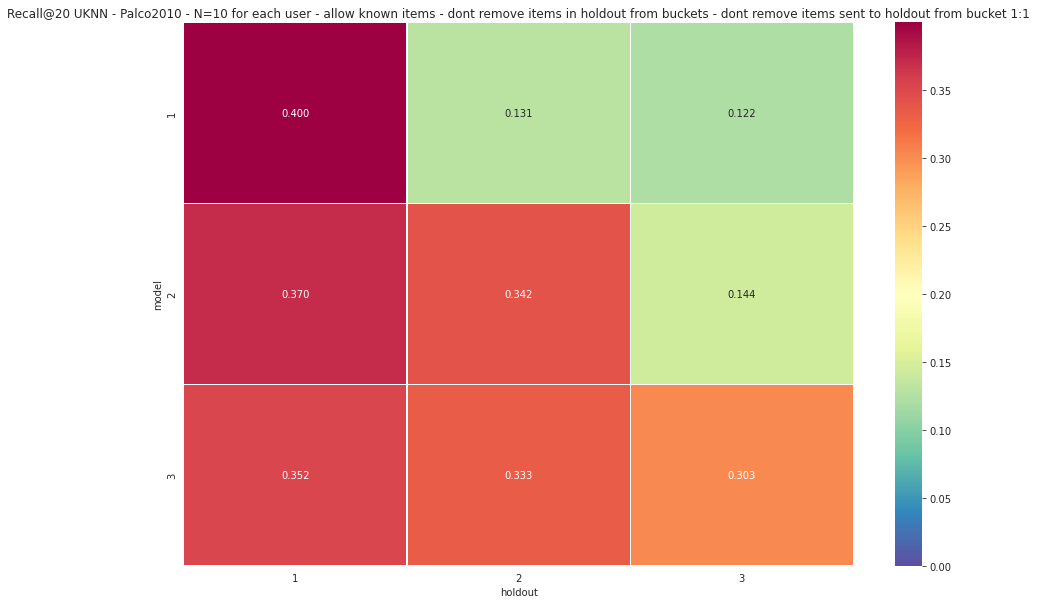

In [25]:
# result with N=10 last interactions of each user - items in holdout are removed from the training data
recall_heatmap(df_exp7,
    round_point=3,
    title='Recall@20 UKNN - Palco2010 - N=10 for each user - allow known items - dont remove items in holdout from buckets - dont remove items sent to holdout from bucket 1:1',
    filepath=None) #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [34]:
arecall = avg_recall(df_exp7)
arecall

0.3481972827442954

In [35]:
BWT, meanBWT = compute_BWT(df_exp7)
BWT, meanBWT

([-0.029431072210065634, -0.02842708199253441], -0.02892907710130002)

In [36]:
FWT = compute_FWT(df_exp7)
FWT
# que itens que usuario utilizou no passado e deixou de consumir o sistema ainda pode recomendar

0.13225308218502113

# Store exp results

In [37]:
# allresults = [df_exp1, df_exp2, df_exp3, df_exp4, df_exp5, df_exp6, df_exp7, df_exp8, df_exp9]
allresults = [df_exp7]

In [38]:
allresults[0].to_csv('../output_10_last_examples/Palco2010_UKNN_result_exp_7')

In [39]:
# df_exp7.to_csv(f'../output_p10_10_examples/UKNN_result_exp_7')

# Read results

In [40]:
import os
import sys
sys.path.append(os.path.abspath('') + '/../..')
from data import ImplicitData, getBucketsHoldouts
from plot_utils import lineplot_recallxholdout, recall_heatmap
from dataset_evaluation_utils import *
from recommenders_implicit import ISGD, RAISGD, RSISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateHoldouts, EvaluateAndStore, EvalPrequential # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout

from datetime import datetime
import joblib
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

def avg_recall(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    return np.mean( np.diag(results_matrix) )

def compute_BWT(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    BWT = []
    n_checkpoints = results_matrix.shape[0]
    for T in range(1, n_checkpoints): # 1 means holdout 2, 2 means 3, so on
        Rti = results_matrix.iloc[T, 0:T] # get models performances' on previous holdouts
        Rii = np.diag(results_matrix)[0:T] # get models performances' on their closest holdouts (diagonal)
        E = sum( Rti - Rii ) # future models performances' - performances' of models closest to holdouts (diagonal)
        BWT.append( E/T ) # store average BWT for model
    return BWT, np.mean( BWT ) # return BWT and average BWT for all models

def compute_FWT(results_matrix): # Díaz-Rodriguez et al. 2018
    upper_tri = results_matrix.to_numpy()[np.triu_indices(results_matrix.shape[0], k=1)]
    return np.mean(upper_tri)

* Exp1: 10 last examples of each user 
* Exp3: 10 last examples, and allow seen items
* Exp5: 10 last examples, and dont remove items that are in holdout from train data, and allow seen items
* Exp7: 10 last examples, and dont remove items that are in holdout from train data, and allow seen items, and dont remove items sent to holdout from bucket
* Exp9: 10 randomly selected examples from each user, and dont remove items that are in holdout from train data, and allow seen items, and dont remove items sent to holdout from bucket

In [42]:
results_10_each_user = {}
results_10_each_user[7]=pd.read_csv(f'../output_10_last_examples/Palco2010_UKNN_result_exp_7', index_col=0)

results_10_each_user = {
    k: {
        'avg_recall': avg_recall( results_10_each_user[k]),
        'BWT': compute_BWT( results_10_each_user[k] )[-1],
        'FWT': compute_FWT( results_10_each_user[k] )
        }
    for k in results_10_each_user.keys()
}

results_10_each_user = pd.DataFrame( results_10_each_user )

results_10_each_user

,7
BWT,-0.028929
FWT,0.132253
avg_recall,0.348197


# ORIGINAL RESULT - DONT CONTINUE


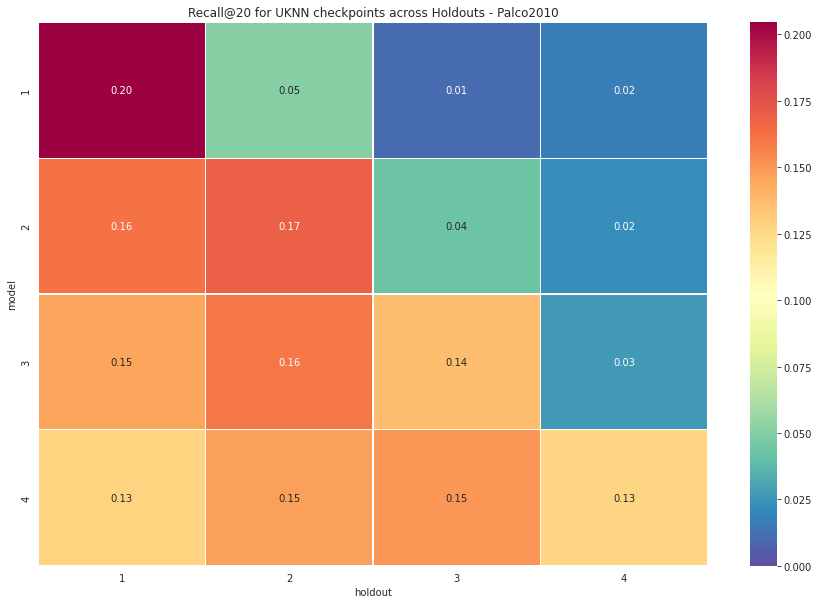

In [ ]:
recall_heatmap(df,
    title='Recall@20 for UKNN checkpoints across Holdouts - Palco2010',
    filepath='images/heatmaps/palco_2010_dump/sample_palco2010 month_bucket UKNN heatmap.png') #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [ ]:
arecall = avg_recall(df)
arecall

0.1591800883392199

In [ ]:
BWT, meanBWT = compute_BWT(df)
BWT, meanBWT

([-0.0429184549356223, -0.03388490253934191, -0.028171497891452207],
 -0.03499161845547214)

In [ ]:
FWT = compute_FWT(df)
FWT
# que itens que usuario utilizou no passado e deixou de consumir o sistema ainda pode recomendar

0.02863289748751155